### Vegetation sensitivity

partioning/aggregating data to see if this provides more robust measures

use `time.month` or `time.day` or `time.week` or `time.dayofyear`
- monthly
- fortnightly
- weekly

https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Frequently_used_code/Virtual_products.ipynb
http://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html
https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Frequently_used_code/Working_with_time.ipynb

In [173]:
import os, sys
import xarray as xr
import numpy as np
import pandas
from matplotlib import pyplot as plt

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
pandas.set_option('display.max_colwidth', 200)
pandas.set_option('display.max_rows', None)
dc = datacube.Datacube(app="veg_sensitivity")

In [174]:
# 13, -28 (Central west QLD, 2010 veg, 2015 bare)
x = (1300000, 1350000)
y = (-2750000, -2700000)

# # 1, -25 (Central NT, 2010 veg, 2015 bare)
# x = (150000, 200000)
# y = (-2450000, -2500000)

# # 16, -40 (Nowra, 2010 veg, 2015 veg)
# x = (1650000, 1700000)
# y = (-3900000, -3950000)

# # -4, -22 (West SA, 2010 bare, 2015 bare - only slight change in veg)
# x = (-400000, -350000)
# y = (-3100000, -3150000)

# # 11, -48 (Southwest Tassie, 2010 veg 2015, bare 2015 - should be all veg/water, problem with obs count)
# x = (1150000, 1200000)
# y = (-4700000, -4750000)

res = (-100, 100)
crs = "EPSG:3577"
time = ("2010-01-01", "2010-12-31")

query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})

# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/r78/LCCS_Aberystwyth/co6850/'

In [175]:
# Load Landsat
# geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
# geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
# geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True, figsize=(10, 10))

#### create the same virtual product as vegetat_veg_cat

In [176]:
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = str(service)+"livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_ingest import gridded_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

# datacube functions to load in a virtual product from recipe
from datacube.virtual import catalog_from_file
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat_veg_testing.yaml')

In [177]:
# load from datacube virtual product
product = catalog['vegetat_veg_cat']
data = product.load(dc, **query)

#### monthly aggregation


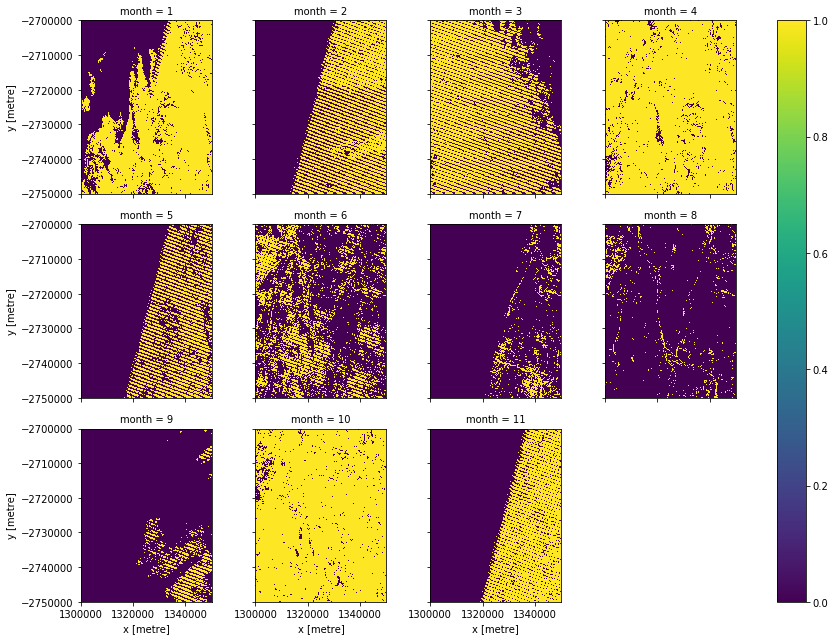

In [178]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
tv.plot(col='month', col_wrap=4)

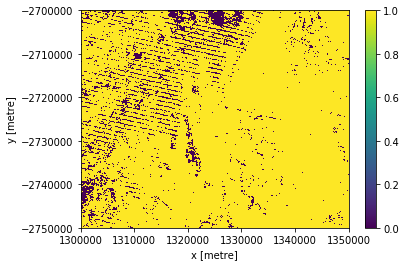

In [180]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 2months
tv_summary_filt = (tv_summary > 2).where(tv_summary.notnull())
tv_summary_filt.plot()

#### fortnightly aggregation 

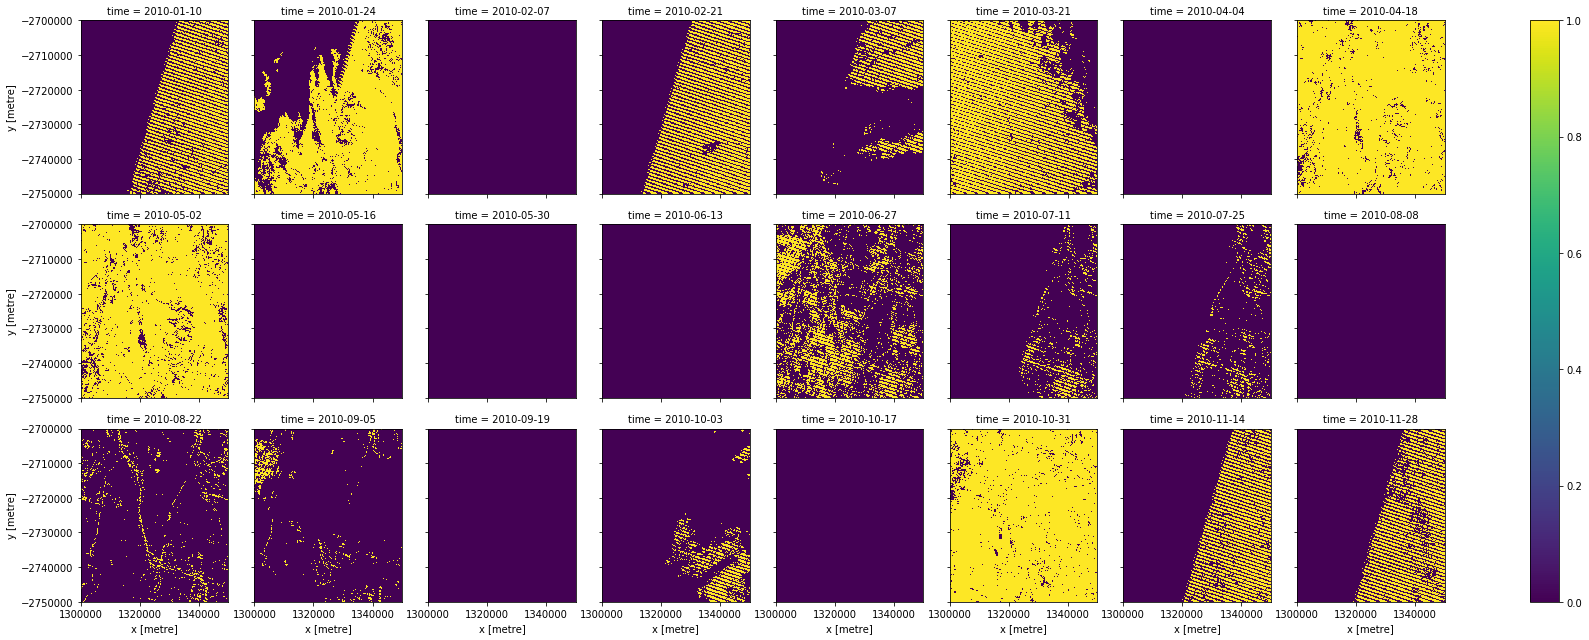

In [171]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_fn = data_mask.resample(time='2w').median()

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_fn['BS'] < data_fn['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_fn['water'] != 128), 0)
tv = tv_mask.where((data_fn['water'] != 132), 0)
tv.plot(col='time', col_wrap=8)

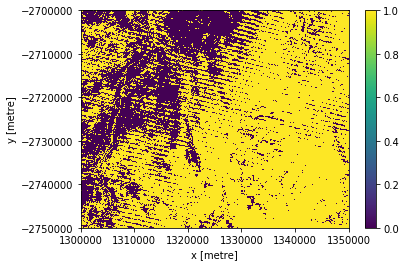

In [172]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='time')

# Create a boolean layer where vegetation is assigned if greater than 4 fortnights
tv_summary_filt = (tv_summary > 4).where(tv_summary.notnull())
tv_summary_filt.plot()

#### weekly aggregation 

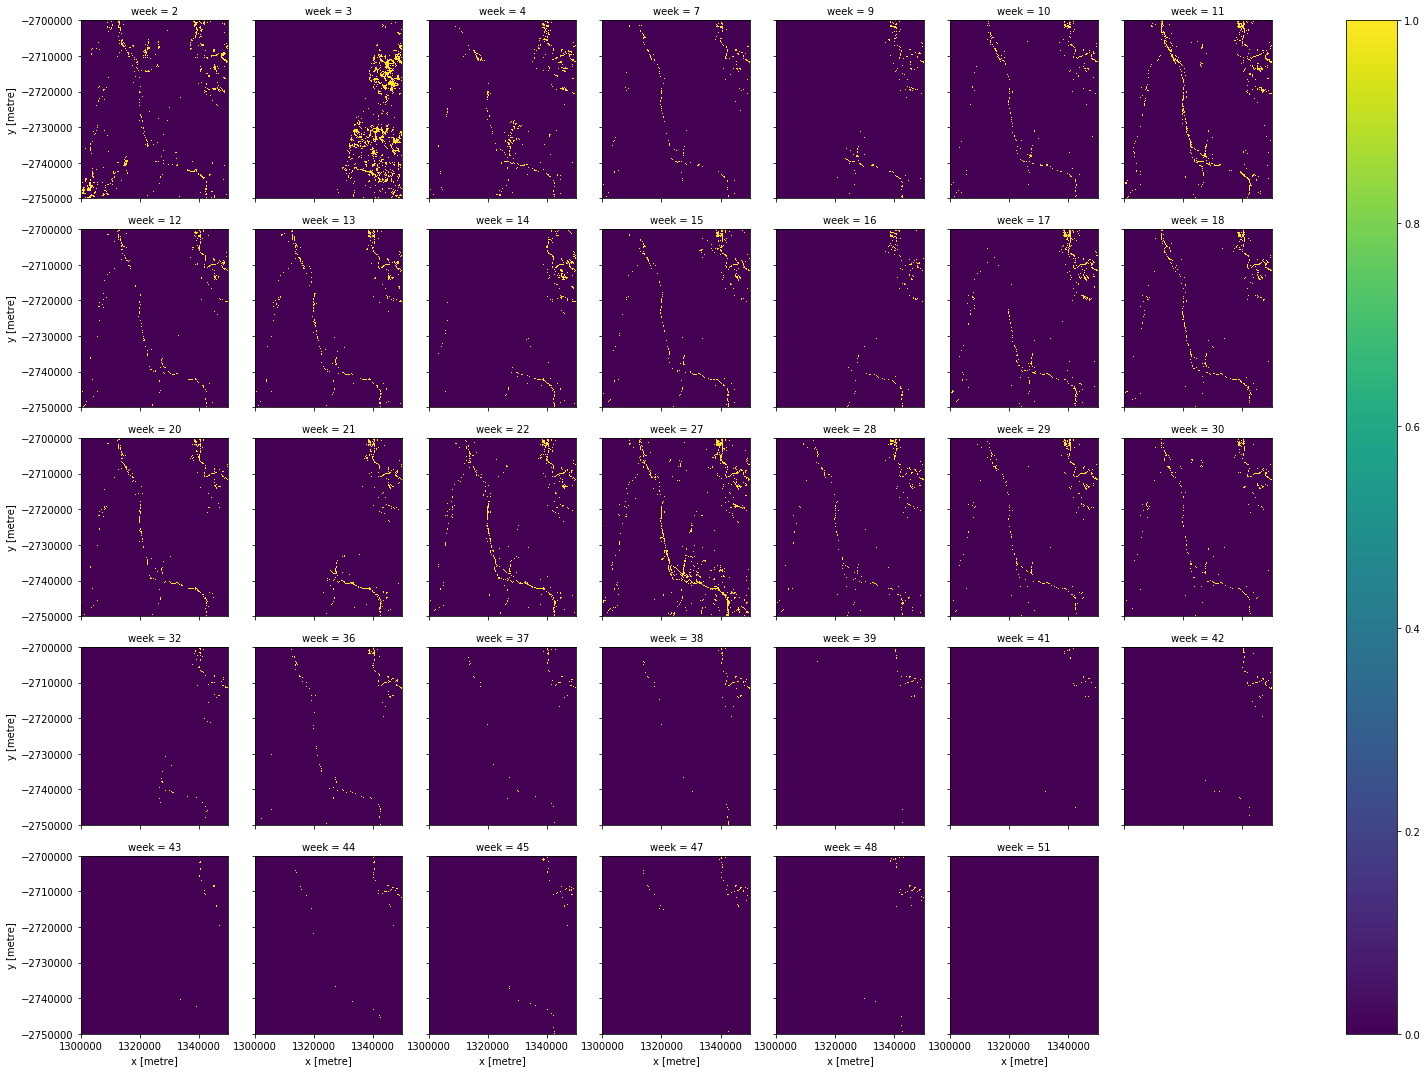

In [77]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_week = data_mask.groupby('time.week').median(dim='time')

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_week['BS'] < data_week['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_week['water'] != 128), 0)
tv = tv_mask.where((data_week['water'] != 132), 0)
tv.plot(col='week', col_wrap=7)

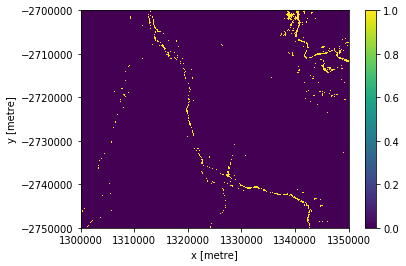

In [78]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='week')

# Create a boolean layer where vegetation is assigned if greater than 8 weeks
tv_summary_filt = (tv_summary > 8).where(tv_summary.notnull())
tv_summary_filt.plot()

#### seasonal aggregation 

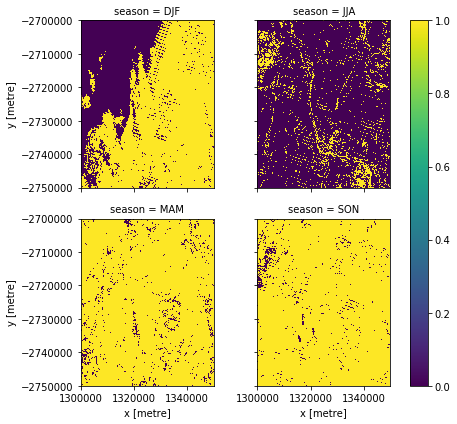

In [141]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_season = data_mask.groupby('time.season').min(dim='time')

# # run pluging rules #
# # Create mask where BS < PV
tv_mask = data_season['BS'] < data_season['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_season['water'] != 128), 0)
tv = tv_mask.where((data_season['water'] != 132), 0)
tv.plot(col='season', col_wrap=2)

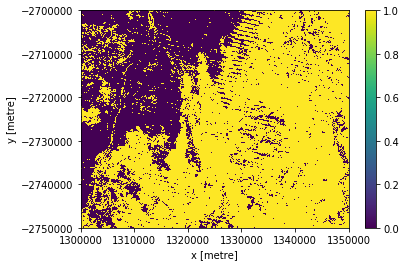

In [143]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='season')

# Create a boolean layer where vegetation is assigned if greater than 6 months
tv_summary_filt = (tv_summary > 2).where(tv_summary.notnull())
tv_summary_filt.plot()

#### PV min, BS max monthly

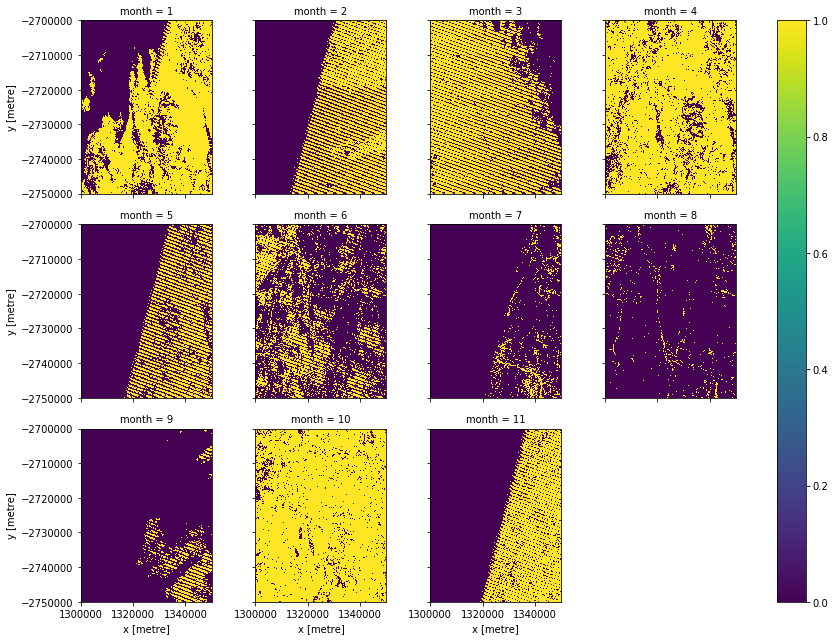

In [144]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month_water = data_mask.water.groupby('time.month').median(dim='time')
data_month_BS = data_mask.BS.groupby('time.month').max(dim='time')
data_month_PV = data_mask.PV.groupby('time.month').min(dim='time')

# add these datasets as variables
data_month_water_ds = data_month_water.to_dataset(name="water_month_median")
data_month_BS_ds = data_month_BS.to_dataset(name="BS_month_max")
data_month_PV_ds = data_month_PV.to_dataset(name="PV_month_min")
# merge back together
variables_xarray_list = []
variables_xarray_list.append(data_month_water_ds)
variables_xarray_list.append(data_month_BS_ds)
variables_xarray_list.append(data_month_PV_ds)
data_month = xr.merge(variables_xarray_list)
data_month

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS_month_max'] < data_month['PV_month_min']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water_month_median'] != 128), 0)
tv = tv_mask.where((data_month['water_month_median'] != 132), 0)
tv.plot(col='month', col_wrap=4)

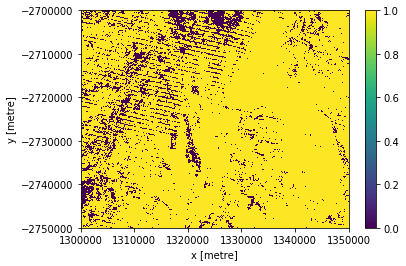

In [145]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 2months
tv_summary_filt = (tv_summary > 2).where(tv_summary.notnull())
tv_summary_filt.plot()

#### Integrating NPV to monthly - WIP

In [84]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0) & (data['NPV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')
data_month

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']
# Create mask where BS < NPV
tv_mask = data_month['BS'] < data_month['PV']



<xarray.Dataset>
Dimensions:  (month: 11, x: 500, y: 500)
Coordinates:
  * y        (y) float64 -2.7e+06 -2.7e+06 -2.7e+06 ... -2.75e+06 -2.75e+06
  * x        (x) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.35e+06 1.35e+06 1.35e+06
  * month    (month) int64 1 2 3 4 5 7 8 9 10 11 12
Data variables:
    BS       (month, y, x) float64 36.5 35.5 35.0 38.0 34.0 ... nan nan nan nan
    PV       (month, y, x) float64 23.5 24.5 23.5 22.5 24.5 ... nan nan nan nan
    NPV      (month, y, x) float64 39.5 39.0 41.5 38.5 41.0 ... nan nan nan nan
    water    (month, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [ ]:


# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
tv.plot(col='month', col_wrap=4)